In [1]:
import os
import numpy as np
import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.backends.cudnn as cudnn
# from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
import pydicom
import cv2

import tensorflow as tf
from keras.models import Model, model_from_json
from keras.layers import Input, LeakyReLU, core, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

W0820 22:05:03.782347 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 22:05:03.783981 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0820 22:05:03.785060 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0820 22:05:04.338397 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

In [3]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()

### Load Train Data

In [4]:
train_fns = glob('./siim/dicom-images-train/*/*/*.dcm')#[:1000] # Temporary
rles_df = pd.read_csv('./siim/train-rle.csv', index_col='ImageId')
rles_df.columns

Index([' EncodedPixels'], dtype='object')

In [5]:
im_height = 1024
im_width = 1024
X_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.float32)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.float32)
has_pneumothorax = []

In [6]:
for n, fn in enumerate(train_fns):
    dcm = pydicom.dcmread(fn)
    X_train[n] = np.expand_dims(dcm.pixel_array/255, axis=2)
    encoded_pixels = rles_df.loc[dcm.SOPInstanceUID][' EncodedPixels']
    if '-1' in encoded_pixels:
        Y_train[n] = np.zeros((1024, 1024, 1))
    else:
        has_pneumothorax.append(n)
        if type(encoded_pixels) == str: # Single Mask
            Y_train[n] = np.expand_dims(rle2mask(encoded_pixels, 1024, 1024).T, axis=2)
        else: # Multiple masks
            Y_train[n] = np.zeros((1024, 1024, 1))
            for x in encoded_pixels:
                Y_train[n] = Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024).T, axis=2)
            #plot_pixel_array_overlay(X_train[n], Y_train[n])
            #break
# Scale X_train
Y_train[Y_train > 0] = 1.
print('has_pneumothorax:', len(has_pneumothorax), '/', len(X_train))
print('Done.')

has_pneumothorax: 2379 / 10675
Done.


In [7]:
print(X_train[has_pneumothorax[0]].min(), X_train[has_pneumothorax[0]].max())
print(Y_train[has_pneumothorax[0]].min(), Y_train[has_pneumothorax[0]].max())

0.0 1.0
0.0 1.0


### Visualize

<Figure size 432x288 with 0 Axes>

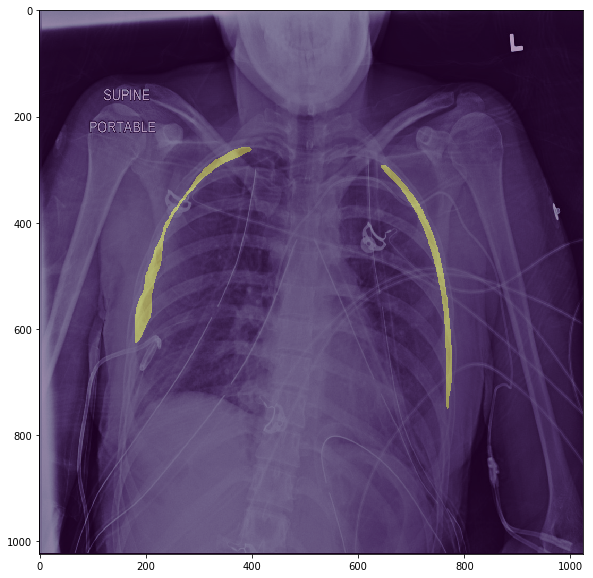

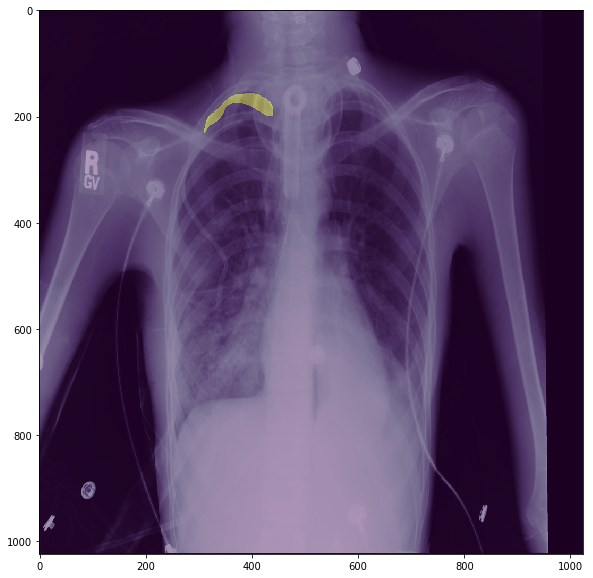

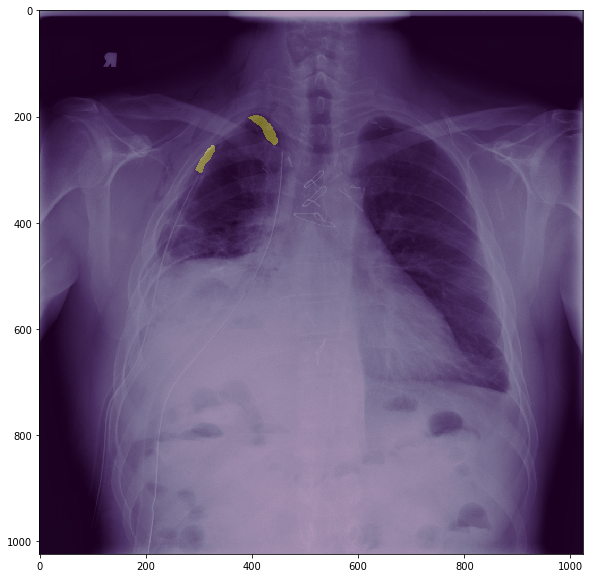

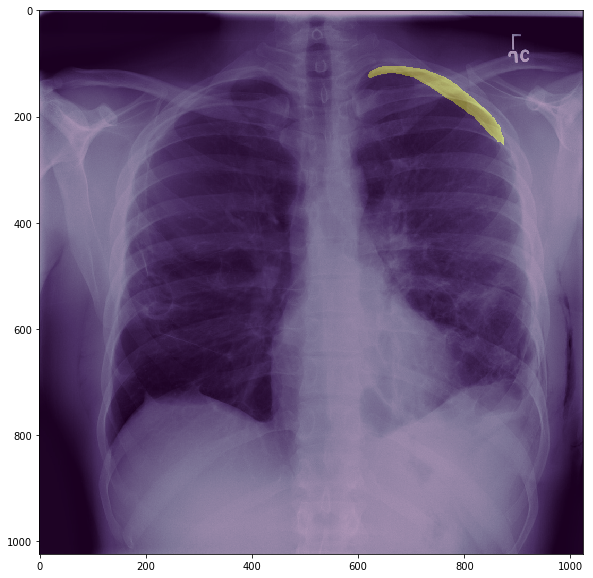

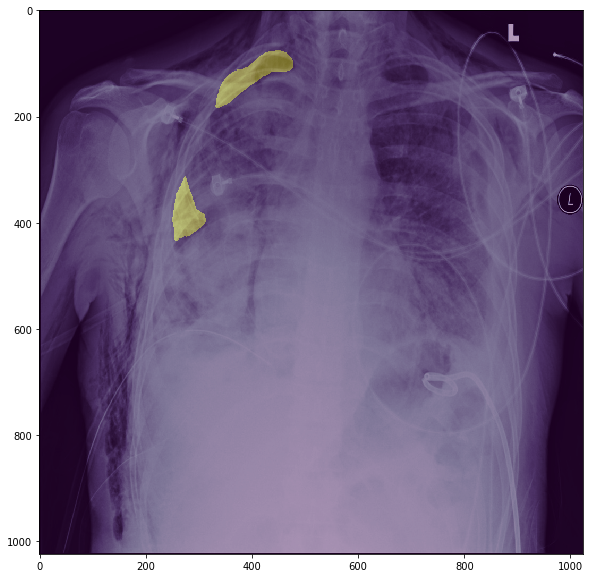

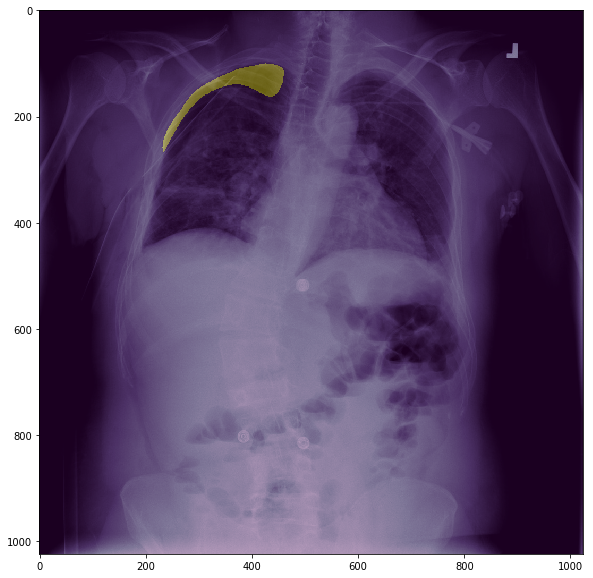

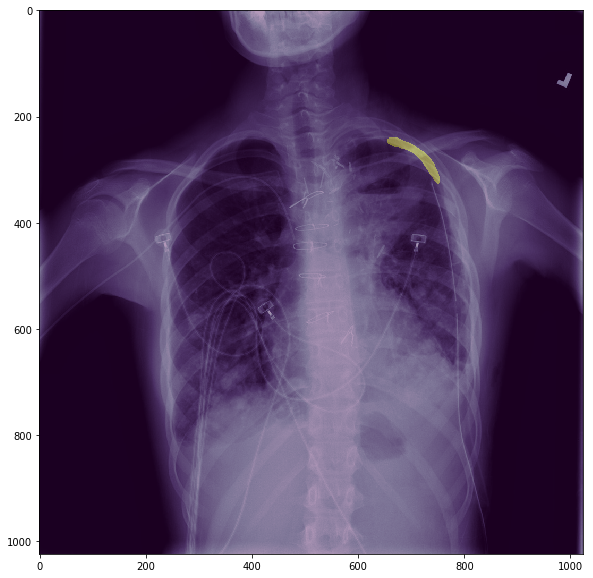

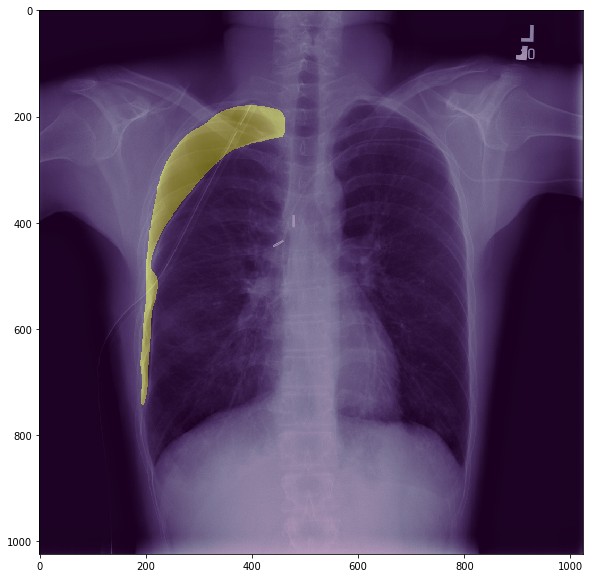

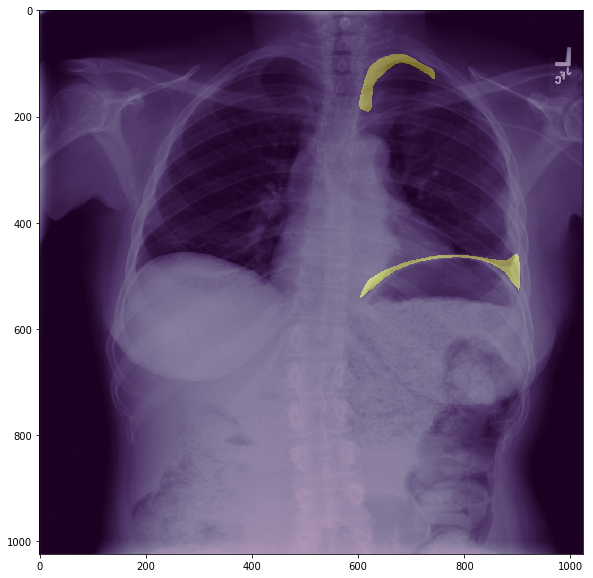

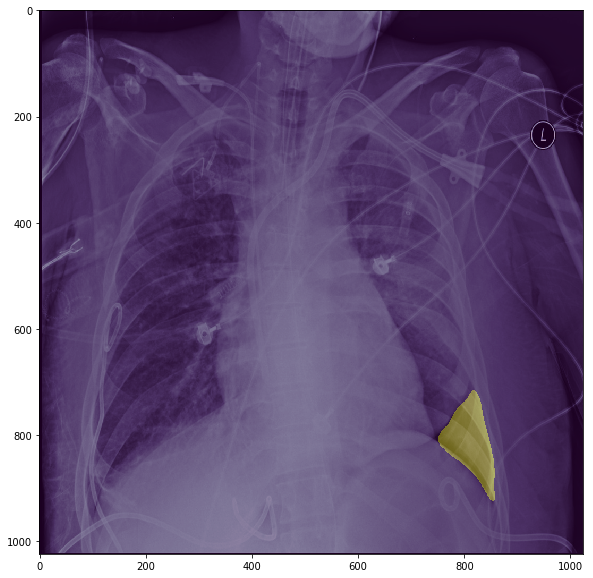

In [8]:
plt.clf()
for i, n in enumerate(has_pneumothorax[0:10]):
    plt.figure(figsize=(10, 10))
    plt.imshow(X_train[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(Y_train[n].squeeze(), alpha=.4)
    plt.show()

### TODO: Patching

### Loss

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [10]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

### Network

In [14]:
inputs = Input((im_height, im_width, 1))

c1 = Conv2D(8, (3, 3), padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU(alpha=0.1)(c1)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(8, (3, 3), padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU(alpha=0.1)(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = LeakyReLU(alpha=0.1)(c2)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(16, (3, 3), padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = LeakyReLU(alpha=0.1)(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = LeakyReLU(alpha=0.1)(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(32, (3, 3), padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = LeakyReLU(alpha=0.1)(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = LeakyReLU(alpha=0.1)(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(64, (3, 3), padding='same') (c4)
c4 = BatchNormalization()(c4)
c4 = LeakyReLU(alpha=0.1)(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = LeakyReLU(alpha=0.1)(c5)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(64, (3, 3), padding='same') (c5)
c5 = BatchNormalization()(c5)
c5 = LeakyReLU(alpha=0.1)(c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), padding='same') (p5)
c55 = BatchNormalization()(c55)
c55 = LeakyReLU(alpha=0.1)(c55)
c55 = Dropout(0.2)(c55)
c55 = Conv2D(128, (3, 3), padding='same') (c55)
c55 = BatchNormalization()(c55)
c55 = LeakyReLU(alpha=0.1)(c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = LeakyReLU(alpha=0.1)(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(64, (3, 3), padding='same') (c6)
c6 = BatchNormalization()(c6)
c6 = LeakyReLU(alpha=0.1)(c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), padding='same') (u71)
c71 = BatchNormalization()(c71)
c71 = LeakyReLU(alpha=0.1)(c71)
c71 = Dropout(0.2)(c71)
c61 = Conv2D(32, (3, 3), padding='same') (c71)
c61 = BatchNormalization()(c61)
c61 = LeakyReLU(alpha=0.1)(c61)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = LeakyReLU(alpha=0.1)(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(32, (3, 3), padding='same') (c7)
c7 = BatchNormalization()(c7)
c7 = LeakyReLU(alpha=0.1)(c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = LeakyReLU(alpha=0.1)(c8)
c8 = Dropout(0.2)(c8)
c8 = Conv2D(16, (3, 3), padding='same') (c8)
c8 = BatchNormalization()(c8)
c8 = LeakyReLU(alpha=0.1)(c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = LeakyReLU(alpha=0.1)(c9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(8, (3, 3), padding='same') (c9)
c9 = BatchNormalization()(c9)
c9 = LeakyReLU(alpha=0.1)(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
#outputs = core.Activation('softmax')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=1e-5)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[my_iou_metric])
model.summary()

W0820 22:09:54.008033 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0820 22:09:54.153975 139819427514112 deprecation.py:506] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0820 22:09:54.214979 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0820 22:09:55.634374 139819427514112 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/optimizers.py:790: Th

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1024, 1024, 8 80          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024, 1024, 8 32          conv2d_3[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1024, 1024, 8 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [ ]:
json_string = model.to_json()
open('./save/u-net.json', 'w').write(json_string)
checkpointer = ModelCheckpoint('./save/best_weights.h5', verbose=1, monitor='val_my_iou_metric', mode='max', save_best_only=True, save_weights_only=False)

In [ ]:
_batch_size = 8

In [ ]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=_batch_size, epochs=10, callbacks=[checkpointer])

In [ ]:
model.save_weights('./save/final_weights.h5', overwrite=True)

### Sanity Check

In [ ]:
X_sanity = X_train[has_pneumothorax[0:_batch_size]]
Y_sanity = Y_train[has_pneumothorax[0:_batch_size]]
X_sanity.shape

In [ ]:
sanity = model.predict(X_sanity, batch_size=_batch_size)

In [ ]:
#sanity[sanity > 0.05] = 1.
#sanity[sanity <= 0.05] = 0.
sanity.max(), sanity.min()
#sanity

In [ ]:
plt.clf()
for n in range(_batch_size):
    plt.figure(figsize=(10, 10))
    plt.imshow(X_sanity[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(Y_sanity[n].squeeze(), alpha=.4)
    plt.show()

In [ ]:
plt.clf()
for n in range(_batch_size):
    plt.figure(figsize=(10, 10))
    #plt.imshow(X_sanity[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(sanity[n].squeeze(), alpha=.2)
    plt.show()

### Load Test Data

In [ ]:
test_fns = glob('./siim/dicom-images-test/*/*/*.dcm')

In [ ]:
im_height, im_width = 1024, 1024
X_test = np.zeros((len(test_fns), im_height, im_width, 1), dtype=np.uint8)
test_ids = np.ndarray((len(test_fns)), dtype='object')

In [ ]:
for n, fn in enumerate(test_fns):
    dcm = pydicom.dcmread(fn)
    X_test[n] = np.expand_dims(dcm.pixel_array, axis=2)
    test_ids[n] = dcm.SOPInstanceUID
print('Done.')

In [ ]:
model = model_from_json(open('./save/u-net.json').read())
model.load_weights('./save/best_weights.h5')

In [ ]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [ ]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
best_threshold = 0.35
min_size = 3500
encoded_pixels = []
df = pd.read_csv('siim/sample_submission.csv')

In [ ]:
preds = model.predict(X_test, batch_size=_batch_size)
print(preds.shape)

In [ ]:
#preds = preds.reshape((-1, 1024, 1024, 1))

### Visualize Predictions

In [ ]:
preds = preds.squeeze()
plt.clf()
for n in range(0, 10):
    plt.figure(figsize=(10, 10))
    plt.imshow(X_test[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(preds[n], alpha=.4)
    plt.show()

In [ ]:
preds[preds[0].max() > 0]

### Generate Submission

In [ ]:
rles = []
threshold = 0.3
for im in preds:
    im = im > threshold
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))

In [ ]:
sub_df = pd.DataFrame({'ImageId': test_ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv', index=False)

In [ ]:
sub_df.loc[sub_df.EncodedPixels == '-1']